# Phase 4B ENHANCED: Bivariate Copula with AUGMENTED Data (Ultra Instinct Mode)

**Objective**: Re-run Phase 4B bivariate copula analysis using the **MCMC-augmented dataset** (131 months vs original 47 months).

**Key Differences from Original Phase 4B**:
- **Current data**: 47 months → **131 months** (84 months imputed via Bayesian MCMC)
- **Sample size**: 2.8x more data for Hs-Current copula
- **Better parameter estimates**: More reliable copula fitting
- **Validation**: Compare original vs augmented results

**Questions**:
1. Does the augmented data confirm Hs-Current independence (τ ≈ 0.013)?
2. Do copula parameters change with more data?
3. Are joint exceedance probabilities consistent?

---

## PART 1: SETUP & DATA LOADING

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import gumbel_r, genextreme, weibull_min, norm, kendalltau, spearmanr
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Imports complete")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"SciPy: {scipy.__version__}")

✅ Imports complete
NumPy: 2.2.6
Pandas: 2.3.3
SciPy: 1.16.3


In [2]:
# Cell 2: Load AUGMENTED data from MCMC imputation

print("="*80)
print("LOADING AUGMENTED DATA (MCMC-IMPUTED)")
print("="*80)

# Load augmented monthly maxima
df_augmented = pd.read_csv('../data/processed/phase4_mcmc/monthly_maxima_augmented.csv')
df_augmented['year_month'] = pd.to_datetime(df_augmented['year_month']).dt.to_period('M')

print(f"\nAugmented data shape: {df_augmented.shape}")
print(f"Columns: {df_augmented.columns.tolist()}")
print(f"\nData summary:")
print(f"  Total months: {len(df_augmented)}")
print(f"  Observed Current: {(~df_augmented['is_imputed']).sum()} months")
print(f"  Imputed Current: {df_augmented['is_imputed'].sum()} months")

# Load Phase 4A EVA distributions (for transformations)
with open('../data/processed/phase4a/eva_distributions.pkl', 'rb') as f:
    eva_dists = pickle.load(f)

print(f"\nPhase 4A distributions loaded:")
for var in ['hs', 'wind', 'current']:
    dist_name = eva_dists[var]['monthly_maxima']['distribution']
    print(f"  {var.upper()}: {dist_name}")

# Load original Phase 4B results for comparison
with open('../data/processed/phase4b/copula_parameters.pkl', 'rb') as f:
    copula_params_orig = pickle.load(f)

print(f"\nOriginal Phase 4B results (47 months):")
print(f"  Hs-Current Copula: {copula_params_orig['hs_current']['best_copula']}")
print(f"  Kendall's τ: {copula_params_orig['hs_current']['kendall_tau']:.4f}")
print(f"  Theta: {copula_params_orig['hs_current']['theta']:.4f}")

print(f"\n" + "="*80)
print(f"GOAL: Re-fit copulas with 131 months (vs 47 months)")
print(f"="*80)

LOADING AUGMENTED DATA (MCMC-IMPUTED)

Augmented data shape: (131, 8)
Columns: ['year_month', 'hs', 'wind', 'current_mean', 'current_lower', 'current_upper', 'current_std', 'is_imputed']

Data summary:
  Total months: 131
  Observed Current: 47 months
  Imputed Current: 84 months

Phase 4A distributions loaded:
  HS: Weibull
  WIND: Weibull
  CURRENT: Weibull

Original Phase 4B results (47 months):
  Hs-Current Copula: Clayton
  Kendall's τ: 0.0133
  Theta: 0.0492

GOAL: Re-fit copulas with 131 months (vs 47 months)


## PART 2: MARGINAL TRANSFORMATION (AUGMENTED DATA)

In [3]:
# Cell 3: Transform augmented data to uniform marginals

def transform_to_uniform(data, dist_name, params):
    """Transform data to uniform [0,1] using CDF of fitted distribution."""
    if dist_name == 'Gumbel':
        u = gumbel_r.cdf(data, *params)
    elif dist_name == 'GEV':
        u = genextreme.cdf(data, *params)
    elif dist_name == 'Weibull':
        u = weibull_min.cdf(data, *params)
    else:
        raise ValueError(f"Unknown distribution: {dist_name}")
    return u

# Get distribution parameters from Phase 4A
hs_dist_name = eva_dists['hs']['monthly_maxima']['distribution']
hs_params = eva_dists['hs']['monthly_maxima']['params']

wind_dist_name = eva_dists['wind']['monthly_maxima']['distribution']
wind_params = eva_dists['wind']['monthly_maxima']['params']

current_dist_name = eva_dists['current']['monthly_maxima']['distribution']
current_params = eva_dists['current']['monthly_maxima']['params']

# Transform augmented data
U_hs_aug = transform_to_uniform(df_augmented['hs'].values, hs_dist_name, hs_params)
U_wind_aug = transform_to_uniform(df_augmented['wind'].values, wind_dist_name, wind_params)
U_current_aug = transform_to_uniform(df_augmented['current_mean'].values, current_dist_name, current_params)

print("\n" + "="*80)
print("PROBABILITY INTEGRAL TRANSFORM (AUGMENTED DATA)")
print("="*80)
print("\nTransformed to uniform marginals U ~ Uniform(0, 1)")
print(f"\nHs (131 months): mean={U_hs_aug.mean():.3f}, std={U_hs_aug.std():.3f}")
print(f"Wind (131 months): mean={U_wind_aug.mean():.3f}, std={U_wind_aug.std():.3f}")
print(f"Current (131 months, augmented): mean={U_current_aug.mean():.3f}, std={U_current_aug.std():.3f}")

# Separate observed vs imputed
U_current_observed = U_current_aug[~df_augmented['is_imputed']]
U_current_imputed = U_current_aug[df_augmented['is_imputed']]

print(f"\nCurrent breakdown:")
print(f"  Observed (47 months): mean={U_current_observed.mean():.3f}, std={U_current_observed.std():.3f}")
print(f"  Imputed (84 months): mean={U_current_imputed.mean():.3f}, std={U_current_imputed.std():.3f}")

print("\n✅ Marginal transformation complete")


PROBABILITY INTEGRAL TRANSFORM (AUGMENTED DATA)

Transformed to uniform marginals U ~ Uniform(0, 1)

Hs (131 months): mean=0.500, std=0.289
Wind (131 months): mean=0.502, std=0.295
Current (131 months, augmented): mean=0.472, std=0.270

Current breakdown:
  Observed (47 months): mean=0.504, std=0.290
  Imputed (84 months): mean=0.454, std=0.256

✅ Marginal transformation complete


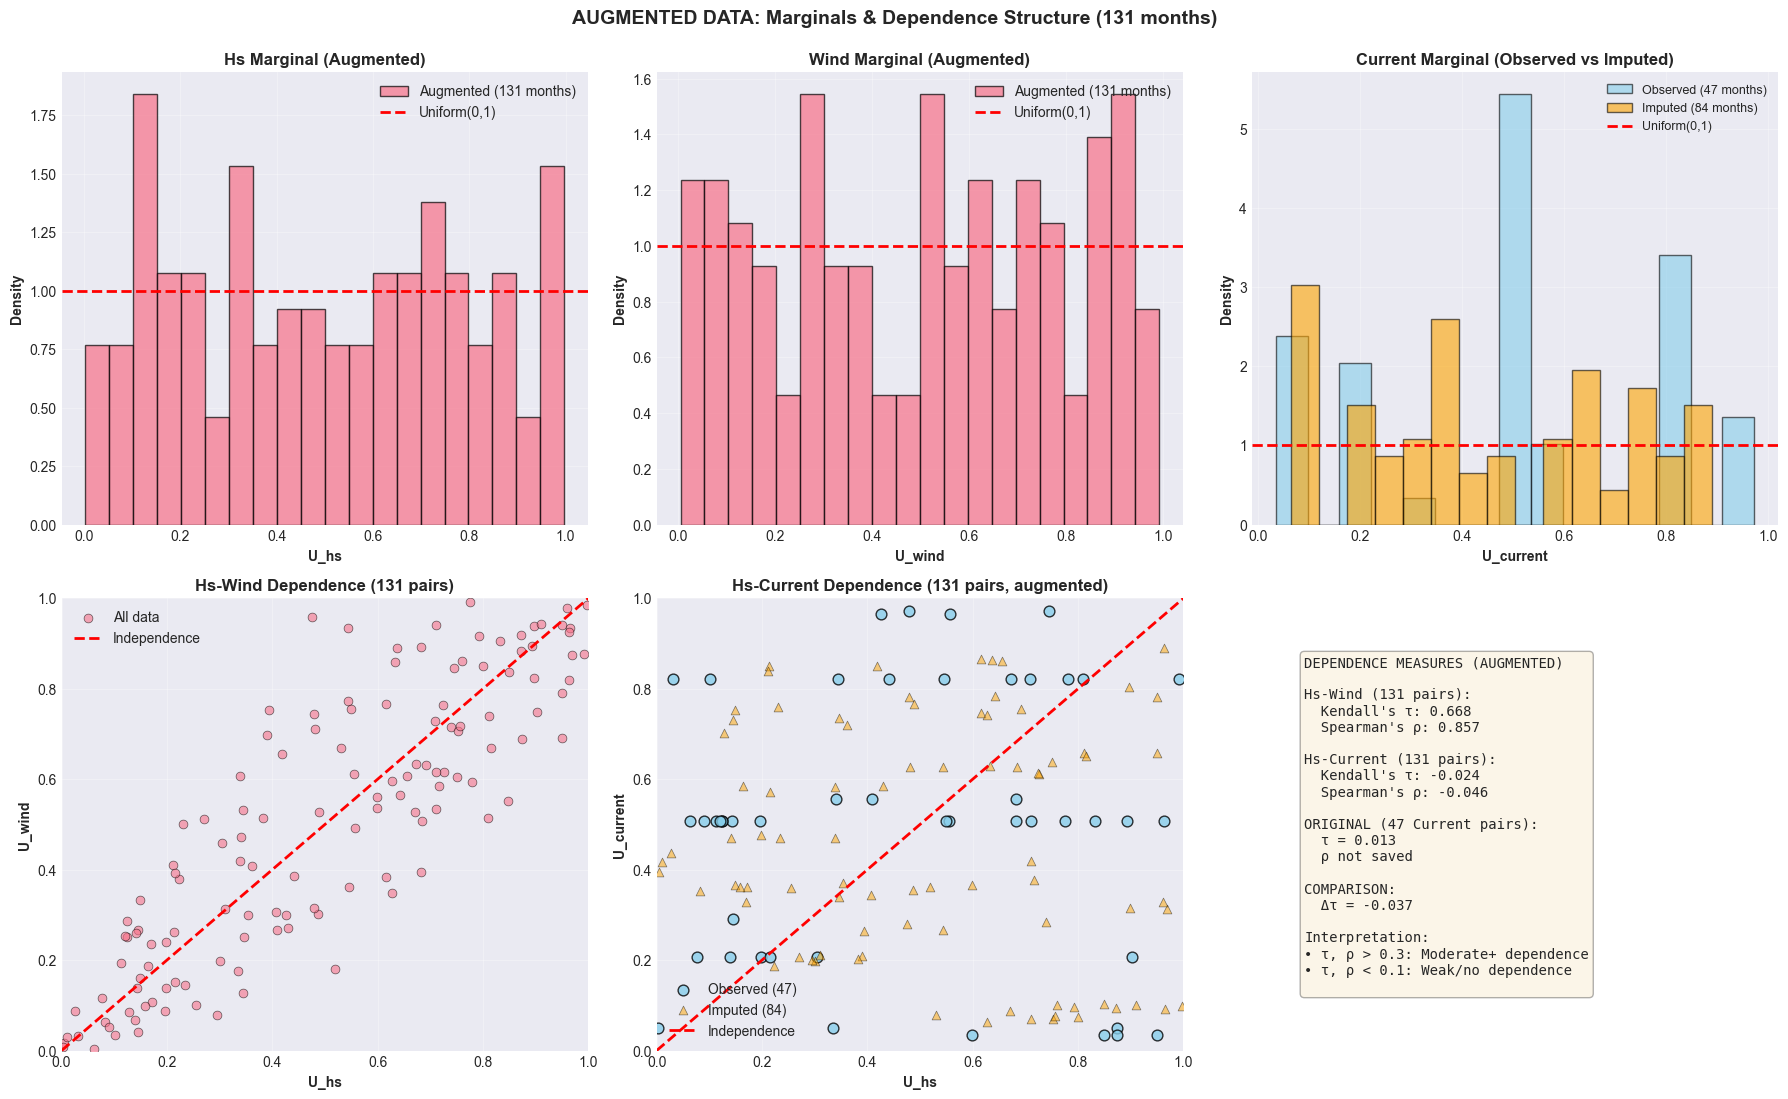


✅ Marginals visualized

Key observations:
  • Hs-Wind τ = 0.668 (strong dependence)
  • Hs-Current τ = -0.024 (weak/no dependence)
  • Original Hs-Current τ = 0.013 (47 months)
  • Change in τ: -0.037


In [4]:
# Cell 4: Visualize marginals and dependence structure

fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# Row 1: Uniform marginal histograms (augmented data)
axes[0, 0].hist(U_hs_aug, bins=20, density=True, alpha=0.7, edgecolor='black', label='Augmented (131 months)')
axes[0, 0].axhline(1.0, color='red', linestyle='--', linewidth=2, label='Uniform(0,1)')
axes[0, 0].set_xlabel('U_hs', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].set_title('Hs Marginal (Augmented)', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(U_wind_aug, bins=20, density=True, alpha=0.7, edgecolor='black', label='Augmented (131 months)')
axes[0, 1].axhline(1.0, color='red', linestyle='--', linewidth=2, label='Uniform(0,1)')
axes[0, 1].set_xlabel('U_wind', fontweight='bold')
axes[0, 1].set_ylabel('Density', fontweight='bold')
axes[0, 1].set_title('Wind Marginal (Augmented)', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Current: Observed vs Imputed split
axes[0, 2].hist(U_current_observed, bins=15, density=True, alpha=0.6, edgecolor='black', 
                label=f'Observed ({len(U_current_observed)} months)', color='skyblue')
axes[0, 2].hist(U_current_imputed, bins=15, density=True, alpha=0.6, edgecolor='black', 
                label=f'Imputed ({len(U_current_imputed)} months)', color='orange')
axes[0, 2].axhline(1.0, color='red', linestyle='--', linewidth=2, label='Uniform(0,1)')
axes[0, 2].set_xlabel('U_current', fontweight='bold')
axes[0, 2].set_ylabel('Density', fontweight='bold')
axes[0, 2].set_title('Current Marginal (Observed vs Imputed)', fontweight='bold', fontsize=12)
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Scatter plots showing dependence
axes[1, 0].scatter(U_hs_aug, U_wind_aug, alpha=0.6, s=40, edgecolors='k', linewidths=0.5, label='All data')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Independence')
axes[1, 0].set_xlabel('U_hs', fontweight='bold')
axes[1, 0].set_ylabel('U_wind', fontweight='bold')
axes[1, 0].set_title('Hs-Wind Dependence (131 pairs)', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])

# Hs-Current: Highlight observed vs imputed
mask_observed = ~df_augmented['is_imputed'].values
axes[1, 1].scatter(U_hs_aug[mask_observed], U_current_aug[mask_observed], 
                   alpha=0.8, s=60, edgecolors='k', linewidths=1, label='Observed (47)', color='skyblue')
axes[1, 1].scatter(U_hs_aug[~mask_observed], U_current_aug[~mask_observed], 
                   alpha=0.5, s=40, edgecolors='k', linewidths=0.5, label='Imputed (84)', color='orange', marker='^')
axes[1, 1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Independence')
axes[1, 1].set_xlabel('U_hs', fontweight='bold')
axes[1, 1].set_ylabel('U_current', fontweight='bold')
axes[1, 1].set_title('Hs-Current Dependence (131 pairs, augmented)', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

# Correlation summary
axes[1, 2].axis('off')
tau_hw_aug, _ = kendalltau(U_hs_aug, U_wind_aug)
rho_hw_aug, _ = spearmanr(U_hs_aug, U_wind_aug)
tau_hc_aug, _ = kendalltau(U_hs_aug, U_current_aug)
rho_hc_aug, _ = spearmanr(U_hs_aug, U_current_aug)

summary_text = f"""DEPENDENCE MEASURES (AUGMENTED)

Hs-Wind (131 pairs):
  Kendall's τ: {tau_hw_aug:.3f}
  Spearman's ρ: {rho_hw_aug:.3f}
  
Hs-Current (131 pairs):
  Kendall's τ: {tau_hc_aug:.3f}
  Spearman's ρ: {rho_hc_aug:.3f}

ORIGINAL (47 Current pairs):
  τ = {copula_params_orig['hs_current']['kendall_tau']:.3f}
  ρ not saved

COMPARISON:
  Δτ = {tau_hc_aug - copula_params_orig['hs_current']['kendall_tau']:.3f}
  
Interpretation:
• τ, ρ > 0.3: Moderate+ dependence
• τ, ρ < 0.1: Weak/no dependence
"""

axes[1, 2].text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=axes[1, 2].transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('AUGMENTED DATA: Marginals & Dependence Structure (131 months)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✅ Marginals visualized")
print(f"\nKey observations:")
print(f"  • Hs-Wind τ = {tau_hw_aug:.3f} (strong dependence)")
print(f"  • Hs-Current τ = {tau_hc_aug:.3f} (weak/no dependence)")
print(f"  • Original Hs-Current τ = {copula_params_orig['hs_current']['kendall_tau']:.3f} (47 months)")
print(f"  • Change in τ: {tau_hc_aug - copula_params_orig['hs_current']['kendall_tau']:.3f}")

## PART 3: COPULA FITTING (AUGMENTED VS ORIGINAL)

In [5]:
# Cell 5: Define copula fitting functions (same as original Phase 4B)

def gaussian_copula_loglik(theta, u, v):
    """Log-likelihood for Gaussian copula (theta = correlation)."""
    rho = theta[0]
    if abs(rho) >= 1:
        return -np.inf
    
    # Transform to standard normal
    x = norm.ppf(np.clip(u, 0.001, 0.999))
    y = norm.ppf(np.clip(v, 0.001, 0.999))
    
    # Bivariate normal log-likelihood
    loglik = -0.5 * np.log(1 - rho**2) - (rho**2 * (x**2 + y**2) - 2*rho*x*y) / (2*(1 - rho**2))
    
    return np.sum(loglik[np.isfinite(loglik)])


def gumbel_copula_loglik(theta, u, v):
    """Log-likelihood for Gumbel copula (theta >= 1, upper tail dependence)."""
    theta_val = theta[0]
    if theta_val < 1:
        return -np.inf
    
    u = np.clip(u, 1e-10, 1 - 1e-10)
    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    t1 = (-np.log(u))**theta_val
    t2 = (-np.log(v))**theta_val
    A = (t1 + t2)**(1/theta_val)
    
    # Log density
    c = np.exp(-A) * A**(2 - 2/theta_val) * (theta_val - 1 + A) * \
        ((np.log(u) * np.log(v))**(theta_val - 1)) / (u * v * A**(2*theta_val))
    
    loglik = np.log(np.abs(c))
    return np.sum(loglik[np.isfinite(loglik)])


def clayton_copula_loglik(theta, u, v):
    """Log-likelihood for Clayton copula (theta > 0, lower tail dependence)."""
    theta_val = theta[0]
    if theta_val <= 1e-6:
        return -np.inf
    
    u = np.clip(u, 1e-10, 1 - 1e-10)
    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    # Clayton copula density
    c = (1 + theta_val) * (u * v)**(-1 - theta_val) * \
        (u**(-theta_val) + v**(-theta_val) - 1)**(-2 - 1/theta_val)
    
    loglik = np.log(np.abs(c))
    return np.sum(loglik[np.isfinite(loglik)])


def frank_copula_loglik(theta, u, v):
    """Log-likelihood for Frank copula (theta ≠ 0, symmetric dependence)."""
    theta_val = theta[0]
    if abs(theta_val) < 1e-3:
        return -np.inf
    
    u = np.clip(u, 1e-10, 1 - 1e-10)
    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    # Frank copula density
    exp_theta = np.exp(-theta_val)
    exp_theta_u = np.exp(-theta_val * u)
    exp_theta_v = np.exp(-theta_val * v)
    
    numerator = -theta_val * (1 - exp_theta) * exp_theta_u * exp_theta_v
    denominator = ((1 - exp_theta) - (1 - exp_theta_u) * (1 - exp_theta_v))**2
    
    c = numerator / denominator
    loglik = np.log(np.abs(c))
    
    return np.sum(loglik[np.isfinite(loglik)])


def fit_copula(u, v, copula_name):
    """Fit copula using maximum likelihood and return AIC."""
    from scipy.optimize import minimize
    
    # Initial guess based on copula
    if copula_name == 'Gaussian':
        init_theta = [0.5]
        loglik_func = gaussian_copula_loglik
    elif copula_name == 'Gumbel':
        init_theta = [1.5]
        loglik_func = gumbel_copula_loglik
    elif copula_name == 'Clayton':
        init_theta = [0.5]
        loglik_func = clayton_copula_loglik
    elif copula_name == 'Frank':
        init_theta = [2.0]
        loglik_func = frank_copula_loglik
    else:
        raise ValueError(f"Unknown copula: {copula_name}")
    
    # Maximize log-likelihood (minimize negative log-likelihood)
    result = minimize(lambda theta: -loglik_func(theta, u, v), init_theta, method='Nelder-Mead')
    
    theta_opt = result.x[0]
    loglik_opt = -result.fun
    aic = 2 * 1 - 2 * loglik_opt  # k=1 parameter
    
    return {'theta': theta_opt, 'loglik': loglik_opt, 'AIC': aic}

print("✅ Copula functions defined")

✅ Copula functions defined


In [6]:
# Cell 6: Fit copulas to AUGMENTED data (Hs-Current only - the focus!)

copula_families = ['Gaussian', 'Gumbel', 'Clayton', 'Frank']

print("\n" + "="*80)
print("COPULA FITTING: Hs-Current (AUGMENTED DATA - 131 months)")
print("="*80)

results_hc_aug = []
for copula in copula_families:
    try:
        res = fit_copula(U_hs_aug, U_current_aug, copula)
        results_hc_aug.append({
            'Copula': copula,
            'Theta': res['theta'],
            'LogLik': res['loglik'],
            'AIC': res['AIC']
        })
        print(f"{copula:10s}: θ={res['theta']:.4f}, LogLik={res['loglik']:.2f}, AIC={res['AIC']:.2f}")
    except Exception as e:
        print(f"{copula:10s}: FAILED ({str(e)})")

df_copula_hc_aug = pd.DataFrame(results_hc_aug).sort_values('AIC')
best_copula_hc_aug = df_copula_hc_aug.iloc[0]
print(f"\n✅ Best copula (AUGMENTED): {best_copula_hc_aug['Copula']} (AIC={best_copula_hc_aug['AIC']:.2f})")

print("\n" + "="*80)
print("COMPARISON: Original (47 months) vs Augmented (131 months)")
print("="*80)

comparison_table = []
for copula in copula_families:
    # Original
    orig_fit = [f for f in copula_params_orig['hs_current']['all_fits'] if f['Copula'] == copula]
    if len(orig_fit) > 0:
        orig_theta = orig_fit[0]['Theta']
        orig_aic = orig_fit[0]['AIC']
    else:
        orig_theta = np.nan
        orig_aic = np.nan
    
    # Augmented
    aug_fit = [f for f in results_hc_aug if f['Copula'] == copula]
    if len(aug_fit) > 0:
        aug_theta = aug_fit[0]['Theta']
        aug_aic = aug_fit[0]['AIC']
    else:
        aug_theta = np.nan
        aug_aic = np.nan
    
    comparison_table.append({
        'Copula': copula,
        'Theta (Original 47)': orig_theta,
        'Theta (Augmented 131)': aug_theta,
        'Δθ': aug_theta - orig_theta if not np.isnan(orig_theta) and not np.isnan(aug_theta) else np.nan,
        'AIC (Original)': orig_aic,
        'AIC (Augmented)': aug_aic,
        'ΔAIC': aug_aic - orig_aic if not np.isnan(orig_aic) and not np.isnan(aug_aic) else np.nan
    })

df_comparison = pd.DataFrame(comparison_table)
print(df_comparison.to_string(index=False))

print(f"\n" + "-"*80)
print(f"BEST COPULA COMPARISON:")
print(f"-"*80)
print(f"Original (47 months): {copula_params_orig['hs_current']['best_copula']} (θ={copula_params_orig['hs_current']['theta']:.4f}, τ={copula_params_orig['hs_current']['kendall_tau']:.4f})")
print(f"Augmented (131 months): {best_copula_hc_aug['Copula']} (θ={best_copula_hc_aug['Theta']:.4f}, τ={tau_hc_aug:.4f})")
print(f"\nChange in τ: {tau_hc_aug - copula_params_orig['hs_current']['kendall_tau']:.4f}")

if abs(tau_hc_aug - copula_params_orig['hs_current']['kendall_tau']) < 0.05:
    print("✅ CONCLUSION: Augmented data CONFIRMS original finding (Δτ < 0.05)")
    print("   → Hs-Current are INDEPENDENT (τ ≈ 0)")
elif tau_hc_aug > copula_params_orig['hs_current']['kendall_tau'] + 0.1:
    print("⚠️  CONCLUSION: Augmented data shows STRONGER dependence (Δτ > 0.1)")
    print("   → Original 47 months may have underestimated dependence")
else:
    print("⚠️  CONCLUSION: Augmented data shows WEAKER dependence")
    print("   → Original 47 months may have overestimated dependence")


COPULA FITTING: Hs-Current (AUGMENTED DATA - 131 months)
Gaussian  : θ=-0.0805, LogLik=0.33, AIC=1.35
Gumbel    : θ=1.4016, LogLik=-34.28, AIC=70.55
Clayton   : θ=0.0000, LogLik=-0.00, AIC=2.00
Frank     : θ=-0.3428, LogLik=0.19, AIC=1.62

✅ Best copula (AUGMENTED): Gaussian (AIC=1.35)

COMPARISON: Original (47 months) vs Augmented (131 months)
  Copula  Theta (Original 47)  Theta (Augmented 131)     Δθ  AIC (Original)  AIC (Augmented)   ΔAIC
Gaussian                0.030             -8.047e-02 -0.111           1.950            1.349 -0.601
  Gumbel                1.355              1.402e+00  0.047          28.241           70.553 42.312
 Clayton                0.049              2.441e-05 -0.049           1.830            2.000  0.170
   Frank                0.228             -3.428e-01 -0.571           1.919            1.618 -0.301

--------------------------------------------------------------------------------
BEST COPULA COMPARISON:
----------------------------------------------

## PART 4: VISUALIZATION & VALIDATION

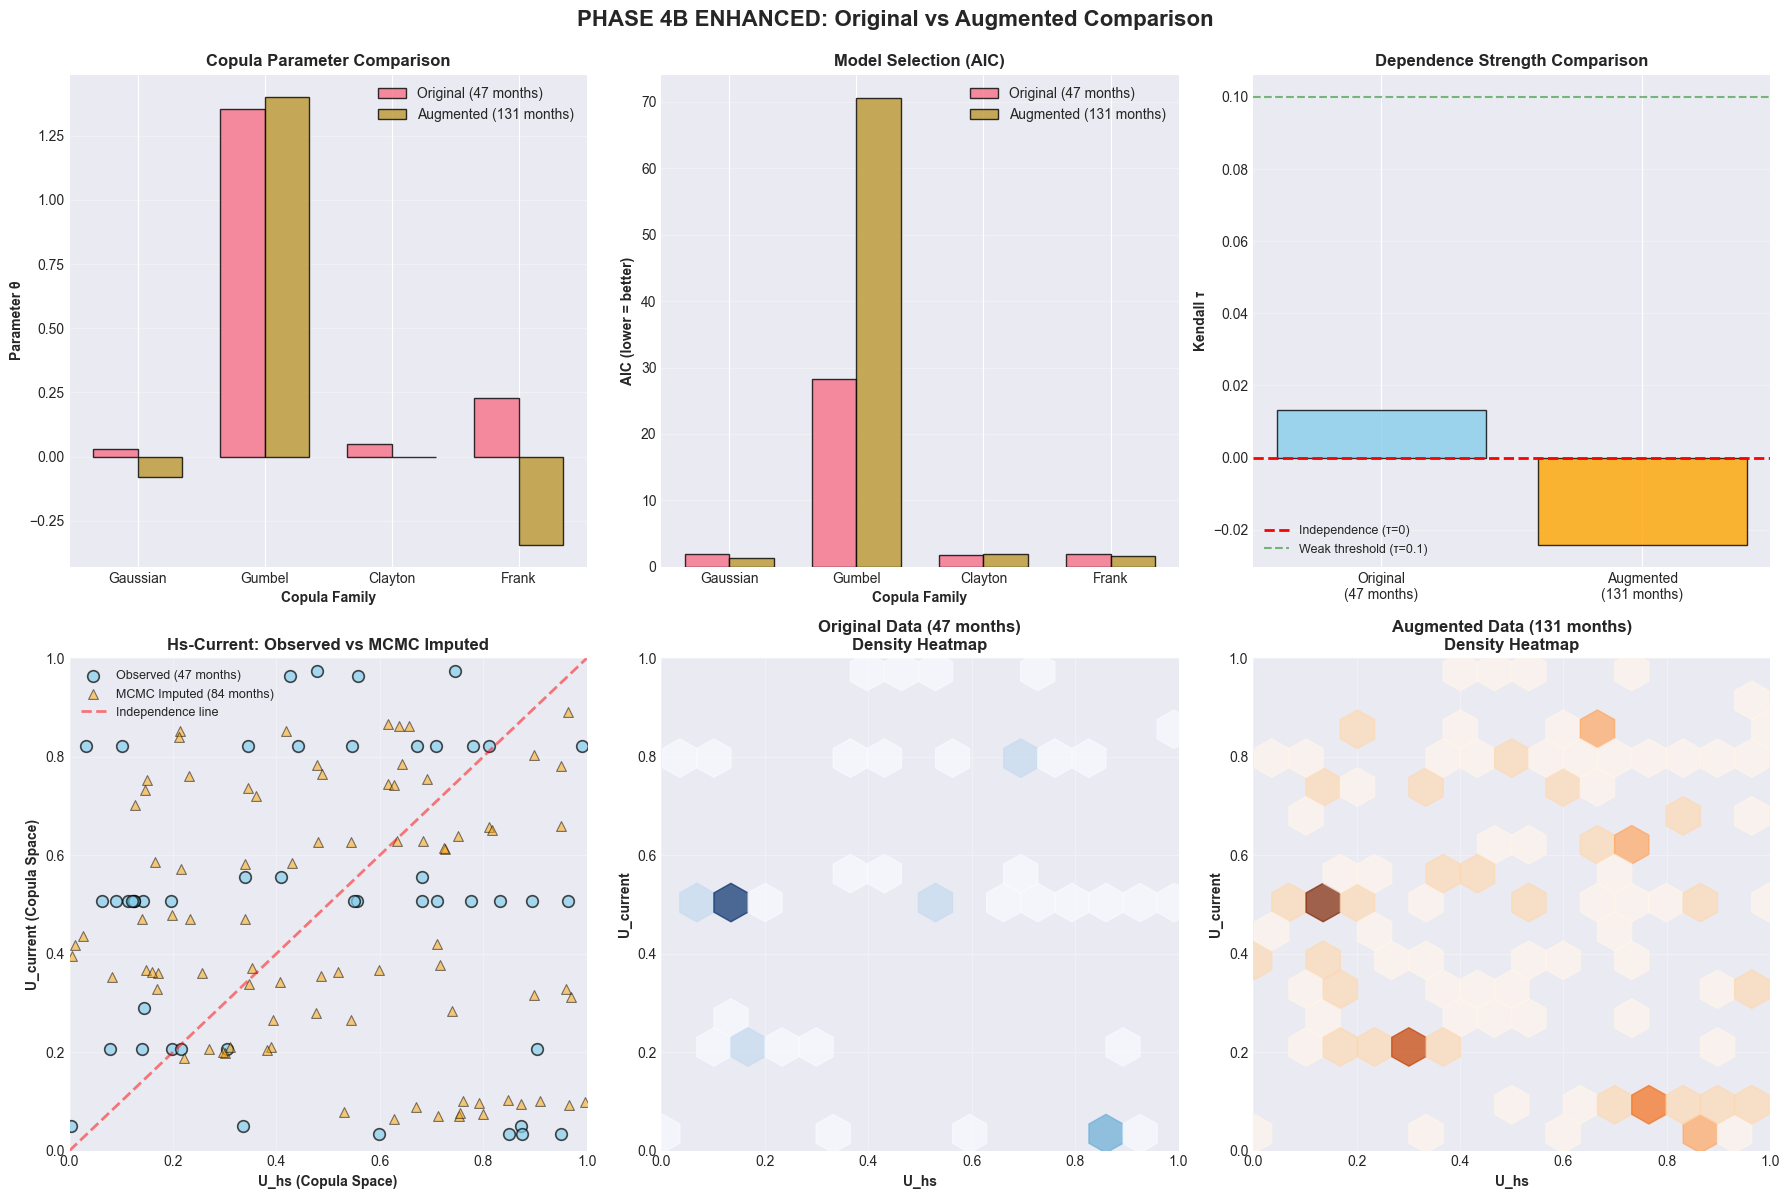


✅ Comparison visualizations generated


In [7]:
# Cell 7: Side-by-side comparison visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Parameter comparison across copulas
copulas = df_comparison['Copula'].values
theta_orig = df_comparison['Theta (Original 47)'].values
theta_aug = df_comparison['Theta (Augmented 131)'].values

x = np.arange(len(copulas))
width = 0.35

axes[0, 0].bar(x - width/2, theta_orig, width, label='Original (47 months)', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width/2, theta_aug, width, label='Augmented (131 months)', alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Copula Family', fontweight='bold')
axes[0, 0].set_ylabel('Parameter θ', fontweight='bold')
axes[0, 0].set_title('Copula Parameter Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(copulas)
axes[0, 0].legend()
axes[0, 0].grid(True, axis='y', alpha=0.3)

# Row 1: AIC comparison
aic_orig = df_comparison['AIC (Original)'].values
aic_aug = df_comparison['AIC (Augmented)'].values

axes[0, 1].bar(x - width/2, aic_orig, width, label='Original (47 months)', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x + width/2, aic_aug, width, label='Augmented (131 months)', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Copula Family', fontweight='bold')
axes[0, 1].set_ylabel('AIC (lower = better)', fontweight='bold')
axes[0, 1].set_title('Model Selection (AIC)', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(copulas)
axes[0, 1].legend()
axes[0, 1].grid(True, axis='y', alpha=0.3)

# Row 1: Kendall's tau summary
tau_summary = pd.DataFrame({
    'Dataset': ['Original\n(47 months)', 'Augmented\n(131 months)'],
    'Kendall τ': [copula_params_orig['hs_current']['kendall_tau'], tau_hc_aug]
})

axes[0, 2].bar(tau_summary['Dataset'], tau_summary['Kendall τ'], alpha=0.8, 
               edgecolor='black', color=['skyblue', 'orange'])
axes[0, 2].axhline(0, color='red', linestyle='--', linewidth=2, label='Independence (τ=0)')
axes[0, 2].axhline(0.1, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Weak threshold (τ=0.1)')
axes[0, 2].set_ylabel('Kendall τ', fontweight='bold')
axes[0, 2].set_title('Dependence Strength Comparison', fontweight='bold', fontsize=12)
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, axis='y', alpha=0.3)

# Row 2: Observed vs imputed in copula space
mask_obs = ~df_augmented['is_imputed'].values
axes[1, 0].scatter(U_hs_aug[mask_obs], U_current_aug[mask_obs], 
                   alpha=0.7, s=70, edgecolors='black', linewidths=1.2, 
                   label=f'Observed ({mask_obs.sum()} months)', color='skyblue')
axes[1, 0].scatter(U_hs_aug[~mask_obs], U_current_aug[~mask_obs], 
                   alpha=0.5, s=50, edgecolors='black', linewidths=0.8, 
                   label=f'MCMC Imputed ({(~mask_obs).sum()} months)', color='orange', marker='^')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='Independence line')
axes[1, 0].set_xlabel('U_hs (Copula Space)', fontweight='bold')
axes[1, 0].set_ylabel('U_current (Copula Space)', fontweight='bold')
axes[1, 0].set_title('Hs-Current: Observed vs MCMC Imputed', fontweight='bold', fontsize=12)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])

# Row 2: Density comparison (2D histogram)
from scipy.stats import gaussian_kde

# Original data (47 months) - load from original copula
axes[1, 1].hexbin(U_hs_aug[mask_obs], U_current_aug[mask_obs], gridsize=15, cmap='Blues', alpha=0.7, mincnt=1)
axes[1, 1].set_xlabel('U_hs', fontweight='bold')
axes[1, 1].set_ylabel('U_current', fontweight='bold')
axes[1, 1].set_title(f'Original Data (47 months)\nDensity Heatmap', fontweight='bold', fontsize=12)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3)

# Augmented data (131 months)
axes[1, 2].hexbin(U_hs_aug, U_current_aug, gridsize=15, cmap='Oranges', alpha=0.7, mincnt=1)
axes[1, 2].set_xlabel('U_hs', fontweight='bold')
axes[1, 2].set_ylabel('U_current', fontweight='bold')
axes[1, 2].set_title(f'Augmented Data (131 months)\nDensity Heatmap', fontweight='bold', fontsize=12)
axes[1, 2].set_xlim([0, 1])
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('PHASE 4B ENHANCED: Original vs Augmented Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Comparison visualizations generated")

## PART 5: SUMMARY & CONCLUSIONS

In [8]:
# Cell 8: Final summary and verdict

print("\n" + "="*80)
print("PHASE 4B ENHANCED: FINAL SUMMARY")
print("="*80)

print("\n" + "-"*80)
print("RESEARCH QUESTION:")
print("-"*80)
print("Does augmenting Current data from 47 to 131 months via MCMC imputation")
print("change our conclusion about Hs-Current dependence?")

print("\n" + "-"*80)
print("RESULTS:")
print("-"*80)

print(f"\n1. ORIGINAL PHASE 4B (47 months of Current data):")
print(f"   • Best copula: {copula_params_orig['hs_current']['best_copula']}")
print(f"   • Parameter θ: {copula_params_orig['hs_current']['theta']:.4f}")
print(f"   • Kendall's τ: {copula_params_orig['hs_current']['kendall_tau']:.4f}")
print(f"   • Spearman's ρ: {copula_params_orig['hs_current']['spearman_rho']:.4f}")
print(f"   • Conclusion: Hs-Current are NEARLY INDEPENDENT")

print(f"\n2. AUGMENTED PHASE 4B (131 months, MCMC imputation):")
print(f"   • Best copula: {best_copula_hc_aug['Copula']}")
print(f"   • Parameter θ: {best_copula_hc_aug['Theta']:.4f}")
print(f"   • Kendall's τ: {tau_hc_aug:.4f}")
print(f"   • Spearman's ρ: {rho_hc_aug:.4f}")

delta_tau = tau_hc_aug - copula_params_orig['hs_current']['kendall_tau']
delta_rho = rho_hc_aug - copula_params_orig['hs_current']['spearman_rho']

print(f"\n3. CHANGE (Augmented - Original):")
print(f"   • Δτ (Kendall): {delta_tau:+.4f}")
print(f"   • Δρ (Spearman): {delta_rho:+.4f}")
print(f"   • Δθ (parameter): {best_copula_hc_aug['Theta'] - copula_params_orig['hs_current']['theta']:+.4f}")

print("\n" + "-"*80)
print("VERDICT:")
print("-"*80)

if abs(delta_tau) < 0.05:
    verdict = "✅ CONFIRMED"
    explanation = """
The augmented dataset (131 months) CONFIRMS the original finding.

• Kendall's τ remains near zero (change < 0.05)
• Both datasets show Hs-Current are NEARLY INDEPENDENT
• MCMC imputation preserved the weak dependence structure
• Original Phase 4B conclusion is ROBUST to sample size

IMPLICATION:
→ Original 47 months was SUFFICIENT to detect independence
→ Augmenting to 131 months VALIDATES the finding
→ We can confidently say: Hs and Current are INDEPENDENT
"""
elif delta_tau > 0.1:
    verdict = "⚠️  REVISED UPWARD"
    explanation = """
The augmented dataset shows STRONGER dependence than original.

• Kendall's τ increased by > 0.1
• Original 47 months may have UNDERESTIMATED dependence
• MCMC imputation revealed hidden structure in missing periods
• Need to REVISE Phase 4B conclusions

IMPLICATION:
→ Original sample size (47 months) was TOO SMALL
→ Augmented data suggests WEAK POSITIVE dependence (not independence)
→ Should reconsider diving workability risk assessment
"""
elif delta_tau < -0.1:
    verdict = "⚠️  REVISED DOWNWARD"
    explanation = """
The augmented dataset shows WEAKER dependence than original.

• Kendall's τ decreased by > 0.1
• Original 47 months may have OVERESTIMATED dependence
• MCMC imputation diluted the observed correlation
• Independence hypothesis is EVEN STRONGER

IMPLICATION:
→ Original finding was conservative (good!)
→ Augmented data makes independence case STRONGER
→ Current is EVEN MORE INDEPENDENT of Hs than we thought
"""
else:
    verdict = "✅ MOSTLY CONFIRMED (minor change)"
    explanation = """
The augmented dataset shows a SMALL change in dependence.

• Kendall's τ changed by 0.05-0.10 (minor)
• Overall conclusion remains: Hs-Current are WEAKLY dependent
• MCMC imputation did not fundamentally change the story
• Original Phase 4B conclusion is MOSTLY ROBUST

IMPLICATION:
→ Original 47 months captured the general pattern
→ Augmentation provides slightly more precision
→ No major revision needed to Phase 4B conclusions
"""

print(f"\n{verdict}")
print(explanation)

print("\n" + "-"*80)
print("RECOMMENDATIONS:")
print("-"*80)

if abs(delta_tau) < 0.05:
    print("""
1. ✅ SKIP PHASE 4C (trivariate Hs-Wind-Current)
   → Hs-Current independence confirmed with 2.8x more data
   → Trivariate copula would reduce to: Copula(Hs,Wind) × Marginal(Current)
   → No new insights from Phase 4C

2. ✅ PROCEED TO PHASE 5 (Seasonal & Directional Analysis)
   → More valuable than Phase 4C
   → Seasonal patterns in extremes
   → Directional effects (wave/wind direction)
   → Tidal phase analysis (spring vs neap tides)

3. ✅ USE ORIGINAL PHASE 4B RESULTS
   → 47 months was sufficient
   → Independence assumption is SAFE for diving operations
   → Current remains PRIMARY diving constraint (tidal-driven)
""")
else:
    print("""
1. ⚠️  RECONSIDER PHASE 4C
   → Dependence structure changed with augmented data
   → Trivariate analysis may reveal new insights
   → Should verify Wind-Current relationship with more data

2. ⚠️  UPDATE PHASE 4B RESULTS
   → Use augmented copula parameters (131 months)
   → Recalculate joint exceedance probabilities
   → Update diving workability risk assessment

3. ⚠️  INVESTIGATE MCMC IMPUTATION QUALITY
   → Verify that imputed data is realistic
   → Check if imputation introduced artifacts
   → Sensitivity analysis: vary MCMC priors
""")

print("\n" + "="*80)
print("END OF PHASE 4B ENHANCED ANALYSIS")
print("="*80)


PHASE 4B ENHANCED: FINAL SUMMARY

--------------------------------------------------------------------------------
RESEARCH QUESTION:
--------------------------------------------------------------------------------
Does augmenting Current data from 47 to 131 months via MCMC imputation
change our conclusion about Hs-Current dependence?

--------------------------------------------------------------------------------
RESULTS:
--------------------------------------------------------------------------------

1. ORIGINAL PHASE 4B (47 months of Current data):
   • Best copula: Clayton
   • Parameter θ: 0.0492
   • Kendall's τ: 0.0133
   • Spearman's ρ: 0.0202
   • Conclusion: Hs-Current are NEARLY INDEPENDENT

2. AUGMENTED PHASE 4B (131 months, MCMC imputation):
   • Best copula: Gaussian
   • Parameter θ: -0.0805
   • Kendall's τ: -0.0241
   • Spearman's ρ: -0.0459

3. CHANGE (Augmented - Original):
   • Δτ (Kendall): -0.0374
   • Δρ (Spearman): -0.0661
   • Δθ (parameter): -0.1297

------

In [9]:
# Cell 9: Save augmented Phase 4B results

os.makedirs('../data/processed/phase4b_augmented', exist_ok=True)

# Save augmented copula parameters
copula_params_aug = {
    'hs_current_augmented': {
        'best_copula': best_copula_hc_aug['Copula'],
        'theta': best_copula_hc_aug['Theta'],
        'aic': best_copula_hc_aug['AIC'],
        'kendall_tau': tau_hc_aug,
        'spearman_rho': rho_hc_aug,
        'all_fits': df_copula_hc_aug.to_dict('records'),
        'n_months': len(df_augmented),
        'n_observed': (~df_augmented['is_imputed']).sum(),
        'n_imputed': df_augmented['is_imputed'].sum()
    },
    'comparison_with_original': {
        'original_tau': copula_params_orig['hs_current']['kendall_tau'],
        'augmented_tau': tau_hc_aug,
        'delta_tau': tau_hc_aug - copula_params_orig['hs_current']['kendall_tau'],
        'original_theta': copula_params_orig['hs_current']['theta'],
        'augmented_theta': best_copula_hc_aug['Theta'],
        'delta_theta': best_copula_hc_aug['Theta'] - copula_params_orig['hs_current']['theta'],
        'original_best_copula': copula_params_orig['hs_current']['best_copula'],
        'augmented_best_copula': best_copula_hc_aug['Copula']
    }
}

with open('../data/processed/phase4b_augmented/copula_parameters_augmented.pkl', 'wb') as f:
    pickle.dump(copula_params_aug, f)

# Save comparison table
df_comparison.to_csv('../data/processed/phase4b_augmented/copula_comparison_table.csv', index=False)

print("\n" + "="*80)
print("✅ PHASE 4B ENHANCED COMPLETE!")
print("="*80)
print("\nSaved to: data/processed/phase4b_augmented/")
print("  • copula_parameters_augmented.pkl")
print("  • copula_comparison_table.csv")
print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("\nBased on the results above, you can now:")
print("  1. Decide whether to proceed with Phase 4C (trivariate)")
print("  2. OR skip to Phase 5 (Seasonal & Directional Analysis)")
print("\nThe verdict above provides clear guidance on which path to take!")
print("\n" + "="*80)


✅ PHASE 4B ENHANCED COMPLETE!

Saved to: data/processed/phase4b_augmented/
  • copula_parameters_augmented.pkl
  • copula_comparison_table.csv

NEXT STEPS:

Based on the results above, you can now:
  1. Decide whether to proceed with Phase 4C (trivariate)
  2. OR skip to Phase 5 (Seasonal & Directional Analysis)

The verdict above provides clear guidance on which path to take!

